# Audio Bulk Processing

In [1]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re

In [2]:
def add_labels_to_excel():
    """Returns dataframe of spreadsheet with labels"""
    df = pd.read_excel('Zebras.Assumption.data_Bing_413 .xlsx', sheet_name=2)
    labels = []
    for filename in df['file']:
        label = re.search("squeal|whinnie|softsnort|snort", filename)
        if label:
            label = label.group(0)
            labels.append(label)
    df['label'] = labels
    return df

In [3]:
df = add_labels_to_excel()

In [4]:
def gen_audio_array(folder_path):
    """ Loads and pads audio files to be of uniform shape"""
    audio_size = 0
    for i in range(len(df['file'])):
        audio, _ = librosa.load(folder_path+df['file'][i])
        if len(audio)>audio_size:
            audio_size = len(audio)
            index_longest = i
    audio_files = np.zeros((413,audio_size))

    for i in range(len(df['file'])):
        audio, _ = librosa.load(folder_path+df['file'][i])
        padding_amount = int((audio_size - len(audio))/2)
        audio_padded = np.pad(audio,padding_amount)
        if (len(audio_padded) % 2) == 0:
            audio_padded = np.append(audio_padded,[0])
        audio_files[i,:] = audio_padded
    return audio_files, audio_size, index_longest
    
audio_files, audio_size, index_longest = gen_audio_array('zebra audio sample_Bing_413/all/')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


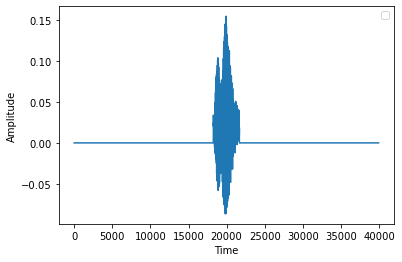

In [5]:
plt.plot(audio_files[1,:])
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [6]:
audio_files.shape

(413, 39923)

In [7]:
audio_labels = df['label']

In [8]:
audio_files.shape

(413, 39923)

In [9]:
audio_labels.shape

(413,)

# Claculate BPMs

In [10]:
BPMs = np.zeros((len(audio_files[:,1])))
for i in range(413):
    BPMs[i] = librosa.beat.tempo(audio_files[i,:])[0]

/var/folders/r2/nzjcjtqn5tl13s8z2f9wr1rm0000gn/T/ipykernel_8828/3740056917.py:3: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  BPMs[i] = librosa.beat.tempo(audio_files[i,:])[0]
/var/folders/r2/nzjcjtqn5tl13s8z2f9wr1rm0000gn/T/ipykernel_8828/3740056917.py:3: FutureWarning: Pass y=[-0.00045069 -0.00067169 -0.00055015 ...  0.00070823  0.00101197
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  BPMs[i] = librosa.beat.tempo(audio_files[i,:])[0]


In [11]:
df['BPM'] = BPMs

In [12]:
df

,file,q25,q50,q75,fpeak,duration,am.var,am.rate,am.extent,harmonicity,label,BPM
0,05011.squeal.trim.wav,1.024,22.542,144.346,509.753,0.234,203.701,25.684,7.931,10.16,squeal,258.398438
1,05073.squeal.trim.wav,4.626,391.921,635.612,537.097,0.155,204.375,16.133,12.668,20.27,squeal,117.453835
2,05074.squeal.trim.wav,9.773,558.276,806.924,769.535,0.087,243.896,5.745,42.452,17.58,squeal,117.453835
3,18023.squeal.trim.wav,378.288,439.051,489.999,442.747,0.165,245.843,9.098,27.022,13.51,squeal,287.109375
4,19002.squeal.trim.wav,414.270,485.271,627.478,449.798,0.138,225.379,18.142,12.423,13.93,squeal,117.453835
...,...,...,...,...,...,...,...,...,...,...,...,...
408,83033.snort.trim.wav,2.413,33.731,162.388,689.083,0.303,413.913,34.701,11.928,6.15,snort,198.768029
409,83035.snort.trim.wav,12.324,106.265,286.088,181.432,0.169,386.167,29.581,13.054,8.15,snort,117.453835
410,83051.snort.trim.wav,1.511,47.826,302.461,197.067,0.549,393.041,25.510,15.407,4.52,snort,184.570312
411,83053.snort.trim.wav,4.978,70.706,211.919,94.333,0.669,477.292,29.899,15.963,7.78,snort,172.265625


# Sample Engineering

In [13]:
def buffer(audio,max_frac_shift):
    shift_max = int(audio.shape[0]*max_frac_shift)
    buffer_array = np.zeros(shift_max)
    audio_buff = np.append(audio,buffer_array, axis=0)
    audio_buff = np.append(buffer_array,audio_buff, axis=0)
    return audio_buff

def shifter(audio,max_frac_shift):
    shift_max = int(audio.shape[0]*max_frac_shift)
    audio_shift = np.roll(audio, random.randint(-shift_max,shift_max))
    return audio_shift

def louder(audio, max_frac_louder):
    max_change = int(max_frac_louder*100)
    random_change = random.randint(100-max_change,max_change)/100
    return audio*random_change

def plot_mel(audio):
    file1_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(y=audio))
    plt.imshow(file1_mel,aspect='auto')
    plt.colorbar(label='dB')
    #plt.xlabel('Frequency Bin')
    #plt.ylabel('Frame')
    plt.show()

In [14]:
def augment_audio(audio_files):
    time_shift = 0.1 # fractional ranges
    vol_shift = 1.1 
    n_samples = audio_files.shape[0]
    width_buffer = int(audio_files.shape[1]*(1+time_shift*2))
    buffer_shape = (n_samples,width_buffer)
    

    audio_files_norm = np.zeros(audio_files.shape) # assume beyond this point (unlabelled)
    audio_files_buff = np.zeros(buffer_shape)
    audio_files_shift1 = np.zeros(buffer_shape)
    audio_files_shift2 = np.zeros(buffer_shape)
    audio_files_loud = np.zeros(buffer_shape) # random intensity shift (whole file)
    audio_files_noisy = np.zeros(audio_files.shape)
    audio_files_noisy_buff = np.zeros(buffer_shape)

    for i in range(n_samples):
        audio_files_norm[i,:] = librosa.util.normalize(audio_files[i,:]) 
        audio_files_buff[i,:]  = buffer(audio_files_norm[i,:],time_shift)
        audio_files_shift1[i,:] = shifter(audio_files_buff[i,:],time_shift)
        audio_files_shift2[i,:] = shifter(audio_files_buff[i,:],time_shift)
        audio_files_loud[i,:] = louder(audio_files_buff[i,:],vol_shift)
        
    noise = np.random.normal(0,0.01,39923)

    ## For noise in buffer:

    for i in range(n_samples):
        for j in range(39923):
            if audio_files_norm[i,j] != 0:
                audio_files_noisy[i,j] =  audio_files_norm[i,j] + noise[j]
            else:
                audio_files_noisy[i,j] =  audio_files_norm[i,j]
        audio_files_noisy_buff[i,:] = buffer(audio_files_noisy[i,:],time_shift)   
        
    data_for_NN = np.zeros((5,n_samples,47907))
    data_for_NN[0,:,:] = audio_files_buff # All normalised 1st
    data_for_NN[1,:,:] = audio_files_shift1
    data_for_NN[2,:,:] = audio_files_shift2
    data_for_NN[3,:,:] = audio_files_noisy_buff
    data_for_NN[4,:,:] = audio_files_loud
        
    return data_for_NN

augmented_samples = augment_audio(audio_files)

In [15]:
#plt.plot(audio_files[index_longest,:],label='raw')
def plot_sample(sample_index):
    plt.plot(augmented_samples[0,sample_index,:],label='buff')
    plt.plot(augmented_samples[1,sample_index,:],label='shift1')
    plt.plot(augmented_samples[2,sample_index,:],label='shift2')
    plt.plot(augmented_samples[3,sample_index,:],label='noisy')
    plt.plot(augmented_samples[4,sample_index,:],label='loud')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

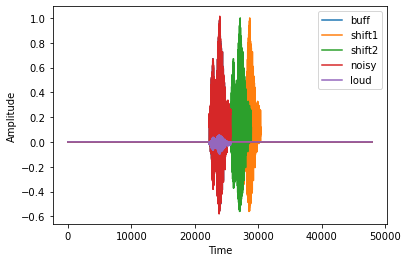

In [18]:
sample_index = 1
plot_sample(sample_index)

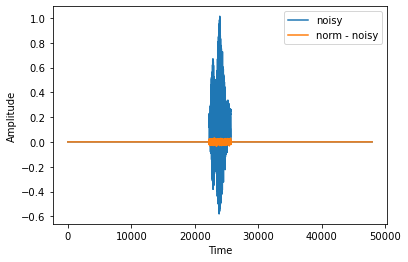

In [19]:
plt.plot(augmented_samples[3,sample_index,:], label='noisy')
plt.plot(augmented_samples[0,sample_index,:]-augmented_samples[3,sample_index,:], label='norm - noisy')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## Sample Rate Options

In [20]:
def hsr_loader(folder_path):
    hsr=22050*2
    audio_size_hsr = int(audio_size*(hsr/22050))
    audio_files_hsr = np.zeros((413,audio_size_hsr))
    for i in range(len(df['file'])):
        audio, _ = librosa.load((folder_path+df['file'][i]), sr=hsr)
        padding_amount = int((audio_size_hsr - len(audio))/2)
        audio_padded = np.pad(audio,padding_amount)
        if (len(audio_padded) % 2) != 0:
            audio_padded = np.append(audio_padded,[0])
        audio_files_hsr[i,:] = audio_padded
    return audio_files_hsr

In [21]:
def lsr_loader(folder_path):
    lsr=22050/2
    audio_size_lsr = int(audio_size*(lsr/22050))+1
    audio_files_lsr = np.zeros((413,audio_size_lsr))
    for i in range(len(df['file'])):
        audio, _ = librosa.load((folder_path+df['file'][i]), sr=lsr)
        padding_amount = int((audio_size_lsr - len(audio))/2)
        audio_padded = np.pad(audio,padding_amount)
        if (len(audio_padded) % 2) != 0:
            audio_padded = np.append(audio_padded,[0])
        audio_files_lsr[i,:] = audio_padded
    return audio_files_lsr

In [22]:
audio_files_hsr = hsr_loader('zebra audio sample_Bing_413/all/')
audio_files_lsr = lsr_loader('zebra audio sample_Bing_413/all/')

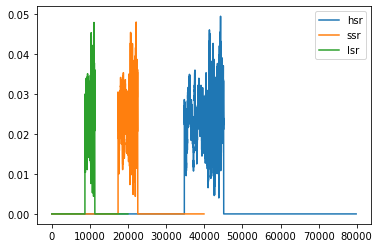

In [23]:
plt.plot(audio_files_hsr[0,:],label='hsr')
plt.plot(audio_files[0,:],label='ssr')
plt.plot(audio_files_lsr[0,:],label='lsr')
plt.legend()
plt.show()

# Spectograms

In [24]:
audio_stft = np.abs(librosa.stft(audio_files[100]))
audio_mel = librosa.feature.melspectrogram(y=audio_files[100])
print(audio_stft.shape)
print(audio_mel.shape)

(1025, 78)
(128, 78)


In [25]:
augmented_samples.shape

(5, 413, 47907)

In [26]:
def calc_stft(augmented_samples):
    n_augments = augmented_samples.shape[0]
    n_samples = augmented_samples.shape[1]
    test_shape = np.abs(librosa.stft(y=augmented_samples[0,0,:])).shape
    sftfs_0 = test_shape[0]
    sftfs_1 = test_shape[1]
    audio_stfts = np.zeros((n_augments,n_samples,sftfs_0,sftfs_1))
    for i in range(n_augments):
        for j in range(n_samples):
            audio_stfts[i,j,:,:] = np.abs(librosa.stft(y=augmented_samples[i,j,:]))
    return audio_stfts

def calc_melstft(augmented_samples):
    n_augments = augmented_samples.shape[0]
    n_samples = augmented_samples.shape[1]
    test_shape = np.abs(librosa.feature.melspectrogram(y=augmented_samples[0,0,:])).shape
    sftfs_0 = test_shape[0]
    sftfs_1 = test_shape[1]
    audio_mel = np.zeros((n_augments,n_samples,sftfs_0,sftfs_1))
    for i in range(n_augments):
        for j in range(n_samples):
            audio_mel[i,j,:,:] = np.abs(librosa.feature.melspectrogram(y=augmented_samples[i,j,:]))
    return audio_mel

In [27]:
audio_stfts = calc_stft(augmented_samples)
audio_mel = calc_melstft(augmented_samples)

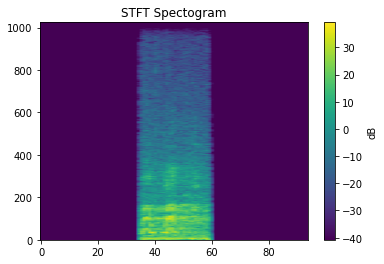

In [28]:
plt.imshow(librosa.amplitude_to_db(audio_stfts[0,100,:,:]),aspect='auto', origin='lower')
plt.title('STFT Spectogram')
plt.colorbar(label='dB')
plt.show()

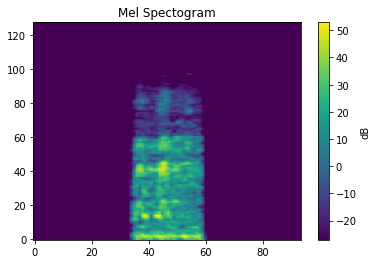

In [29]:
plt.imshow(librosa.amplitude_to_db(audio_mel[0,100,:,:]),aspect='auto',origin='lower')
plt.title("Mel Spectogram")
plt.colorbar(label='dB')
plt.show()

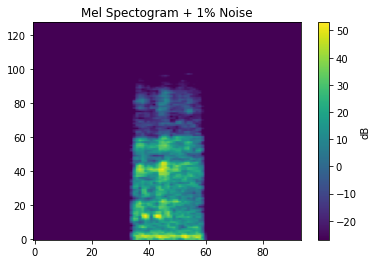

In [30]:
plt.imshow(librosa.amplitude_to_db(audio_mel[3,100,:,:]),aspect='auto', origin='lower')
plt.title("Mel Spectogram + 1% Noise")
plt.colorbar(label='dB')
plt.show()

/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
        0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
        0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
        0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
        0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
        0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
        0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
        0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
        0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
        0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
        0.4

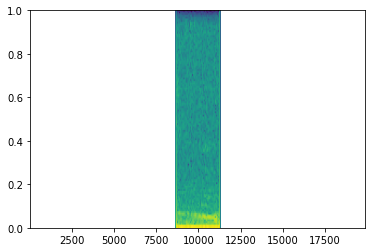

In [31]:
plt.specgram(audio_files[0])